In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc 

In [43]:
# read in the data and eliminate unnecessary index columns
df = pd.read_csv("final_no_pct.csv")
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [44]:
# convert playoff result to categorical variable
df['Playoff_Result'] = df['Playoff_Result'].astype('category')

In [45]:
# get the necessary columns
df_sb = df.iloc[:,[1,2,30,32,4,8,19,22,35,25,11,13,16,63,69,57,53,44,10]].copy() 

In [46]:
# create binary indicator variable for whether or not a team won the superbowl -- use this as the response
df_sb['Wins_SB'] = (df_sb['Playoff_Result'] == 5).astype('int')
df_sb['Wins_SB'] = df_sb['Wins_SB'].astype('category')

In [47]:
# no longer interested in playoff result variable
df_sb = df_sb.drop(['Playoff_Result'], axis=1)

In [66]:
# using just the data and not ranks
X = df_sb.drop(['Wins_SB'], axis=1)
y = df_sb['Wins_SB']

In [48]:
# ranking all stats descending
cols = df_sb.columns
df_rank = df_sb.copy()
for i in cols:
    if i == 'Wins_SB' or i == 'Year':
        continue
    else:
        df_rank[i] = df_rank.groupby(['Year'])[i].rank(ascending=False)

In [96]:
# ranking offensive stats descending and defensive stats ascending
cols = df_sb.columns
df_rank = df_sb.copy()
for i in cols:
    if i == 'Wins_SB' or i == 'Year': 
        continue
    else:
        if i in ['O_Sc%', 'O_EXP', 'W', 'PD', 'OP_Yds', 'O_NY/A', 'O_3D%', 'OR_TD', 'T_O_Yds', 'O_Y/P', 'O_1stD', 'SoS']:
            df_rank[i] = df_rank.groupby(['Year'])[i].rank(ascending=False)
        else:
            df_rank[i] = df_rank.groupby(['Year'])[i].rank(ascending=True)

In [97]:
# use both the data and the ranks (descending)
cols = df_sb.columns
df_rank = df_sb.copy()
for i in cols:
    if i == 'Wins_SB' or i == 'Year' or i == 'SoS': # don't rank SoS?
        continue
    else:
        df_rank[i + "_rank"] = df_rank.groupby(['Year'])[i].rank(ascending=False)

In [49]:
X = df_rank.drop(['Wins_SB'], axis=1)
y = df_rank['Wins_SB']

In [67]:
# find the best tuning parameters for the data
# use roc_auc as performance metric
clf = DecisionTreeClassifier(random_state=100)
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas

# use 5-fold CV to select the optimal tuning parameter
kfoldcv_accuracy = np.zeros(ccp_alphas.shape[0])
kfold = KFold(n_splits = 5, random_state=100, shuffle=True)
for i in range(ccp_alphas.shape[0]):
    model = RandomForestClassifier(random_state=100, ccp_alpha= ccp_alphas[i])
    kfoldcv_accuracy[i] = np.mean(cross_val_score(model, X, y, cv = kfold, scoring='roc_auc'))

In [68]:
# find the tuning parameter with the best performance
best_ind = np.argmax(kfoldcv_accuracy)
print(best_ind) 
best = ccp_alphas[best_ind]
print(best)

12
0.015394751987282379


In [69]:
# Use GridSearchCv to tune other hyperparameters

param_grid = {'max_depth': range(3,15), 'max_features':['log2','sqrt'], 'ccp_alpha':[0.0, best]}

#Initialize the classifier
rf_clf = GridSearchCV(RandomForestClassifier(random_state=100), param_grid, 
                      scoring='roc_auc',refit=False, n_jobs=-1)

In [70]:
x = rf_clf.fit(X, y)

print(x.best_params_, x.best_score_)

{'ccp_alpha': 0.0, 'max_depth': 3, 'max_features': 'log2'} 0.6987858220211162


In [71]:
# store the optimal hyperparameters
alpha = x.best_params_.get('ccp_alpha')
md = x.best_params_.get('max_depth')
mf = x.best_params_.get('max_features')

In [72]:
# this function fits a random forest classification model with the specified hyperparameters to the data and returns
# a tuple containing the test error and auc score
def fit_model(train, test, alpha, md, mf):
    # separate the response
    X_train = train.drop(['Wins_SB'], axis=1)
    X_test = test.drop(['Wins_SB'], axis=1)
    y_train = train['Wins_SB']
    y_test = test['Wins_SB']
    
    # try using SMOTE
    oversample = SMOTE()

    X_train, y_train = oversample.fit_resample(X_train, y_train)
    
    # fit model with best parameters
    final_cl_rf = RandomForestClassifier(ccp_alpha=alpha, max_depth=md, max_features=mf, 
                                         random_state=100)
    final_cl_rf.fit(X_train, y_train)
    
    # compute the predicted probabilities of a team winning the superbowl
    # set the superbowl winner as the team with the highest such probability
    pred_probs = final_cl_rf.predict_proba(X_test)
    y_pred = np.zeros(X_test.shape[0])
    y_pred[pred_probs[:,0].argmax()] = 1

    # calculate the test error
    te = np.mean(y_pred != y_test)
    
    # get auc score
    y_pred_prob = final_cl_rf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
    roc_auc =  auc(fpr, tpr)
    
    return [te, roc_auc]
    

In [73]:
# for each year, hold that year out as a test set and use the data for remaining years as training
# fit a random forest classification model to the data (using each year as test set)
# and store the test error and auc score for each model
years = list(range(2000,2023))

test_errors = list()
aucs = list()

for year in years:
    train = df_sb[df_sb['Year']!=year]
    test =  df_sb[df_sb['Year']==year]
    
    test_errors.append(fit_model(train, test, alpha, md, mf)[0])
    aucs.append(fit_model(train, test, alpha, md, mf)[1])
    

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [74]:
# get the test errors
test_errors

[0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285]

In [75]:
# get the auc scores
aucs

[0.6363636363636364,
 0.2727272727272727,
 0.9090909090909091,
 1.0,
 0.8181818181818181,
 0.4545454545454546,
 0.7272727272727273,
 0.09090909090909094,
 1.0,
 0.18181818181818177,
 0.5454545454545454,
 0.18181818181818177,
 0.18181818181818177,
 0.9090909090909091,
 0.4545454545454546,
 0.5454545454545454,
 0.4545454545454546,
 0.4545454545454546,
 0.4545454545454546,
 1.0,
 0.9230769230769231,
 1.0,
 0.8461538461538461]

In [76]:
# get the averages
avg_te = np.mean(test_errors)
avg_auc = np.mean(aucs)

In [77]:
avg_te

0.16356107660455482

In [78]:
avg_auc

0.610519914867741

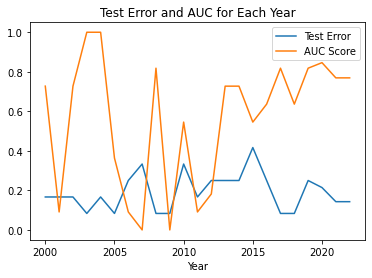

In [111]:
# plot the test errors and aucs against year
plt.plot(years, test_errors, label='Test Error')
plt.plot(years, aucs, label='AUC Score')
plt.legend()
plt.title('Test Error and AUC for Each Year')
plt.xlabel('Year')
plt.show();

# Comparing Results:

In [ ]:
# when using just the raw data we get avg_te = 0.0782, avg_auc = 0.6825
# when using just the data and SMOTE we get avg_te = 0.2857 and avg_auc = 0.6157
# using both the raw data and the descending ranks we get avg_te = 0.0818, avg_auc = 0.6752
# using both data and ranks and SMOTE we get avg_te = 0.1920, avg_auc = 0.5622
# when using just the descending ranks we get avg_te = 0.0818 and avg_auc = 0.7182 **use this model?
# when using desc ranks and SMOTE we get avg_te = 0.1641, avg_auc = 0.5765
# when using just the ranks ascending we get avg_te = 0.0818 and avg_auc = 0.6309
# when using desc offensive ranks and asc defensive ranks we get avg_te = 0.0818, avg_auc = 0.6400

In [ ]:
# HOWEVER (without SMOTE) THE MODELS PREDICT ALL 0's (no superbowl winners) 